In [1]:
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.snowball import DutchStemmer
from nltk.stem.porter import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import copy
import random

from pathlib import Path
from pprint import pprint
from collections import defaultdict
import scipy.stats as stats


nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/henning/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/henning/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
stopwords = nltk.corpus.stopwords.words('dutch')
max_art_len=100
data_path="./Data/DPG_nov19/10k_time_split_n_rnd_users"
stemmer = DutchStemmer()

In [3]:
# preprocessing funcs

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [4]:
def load_raw_news_data(news_path: str):
    file_path = Path(news_path).joinpath('news_data.pkl')
    news_data = pickle.load(file_path.open('rb'))  # dict
    
    return news_data['all']

def load_raw_user_data(data_path: str):
    file_path = Path(data_path).joinpath('user_data.pkl')
    user_data = pickle.load(file_path.open('rb'))  # dict
    
    return user_data

In [5]:
news_data = load_raw_news_data(data_path)

In [6]:
next(iter(news_data.items()))

('362367c',
 {'text': "ILvA wil gele zakken vervangen door container ILvA wil de afvalberg kleiner maken en stelt voor om vanaf 2021 de gele zakken te vervangen door een container. De afvalberg is groot en de verwerking ervan is erg duur. De afgelopen 10 jaar heeft ILvA het afvaltarief niet aangepast, terwijl de kostprijs voor de afvalverwerking in die periode fors is gestegen. Hierdoor moeten de gemeenten in verhouding steeds meer bijleggen, bovenop wat de inwoners betalen aan stickers en zakken. De inwoners betalen via de gemeentebelasting dus mee, maar worden niet gesensibiliseerd om minder afval te hebben. Goede sorteerders worden steeds minder beloond en daarom kiest ILvA voor de invoering van 'diftar', waarbij je betaalt per kilogram restfractie en GFT, en niet voor een algemene prijsverhoging, waarbij de zakken en stickers voor iedereen duurder zouden worden. Telkens men een container zal komen ledigen, zal de persoon in kwestie al minstens 0,25 euro betalen, een forfaitaire aan

In [7]:
next(iter(news_data))

'362367c'

In [8]:
len(news_data)

39212

In [9]:
text=news_data['362367c']['text']

In [7]:
proc_news = {art_id: preprocess(vals['text']) for art_id, vals in news_data.items()}

In [8]:
art_id2idx = {art_id: i for i, art_id in enumerate(news_data.keys())}

In [42]:
#create dictionary
id2word = gensim.corpora.Dictionary(proc_news.values())

print("Unfilt corp len: {}".format(len(id2word)))
id2word.filter_extremes(no_below=15, no_above=0.2, keep_n=100000)
print("Filtered: {}".format(len(id2word)))

#create corpus
corpus = [id2word.doc2bow(text) for text in proc_news.values()]

Unfilt corp len: 193083
Filtered: 24623


In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aangepast', 1),
  ('afgelop', 1),
  ('afval', 2),
  ('afvalberg', 2),
  ('afvalverwerk', 1),
  ('algemen', 1),
  ('beloond', 1),
  ('betaalt', 1),
  ('betal', 4),
  ('bevindt', 1),
  ('bovenop', 1),
  ('container', 4),
  ('containerpark', 1),
  ('daarnaast', 1),
  ('daarom', 1),
  ('diftar', 1),
  ('dur', 1),
  ('duurder', 1),
  ('eerst', 1),
  ('ervan', 1),
  ('euro', 3),
  ('for', 1),
  ('gat', 1),
  ('gel', 2),
  ('gemeent', 1),
  ('gesteg', 1),
  ('goed', 1),
  ('grot', 1),
  ('hierdor', 1),
  ('iederen', 1),
  ('invoer', 1),
  ('inwoner', 2),
  ('kiest', 1),
  ('kilogram', 2),
  ('kleiner', 1),
  ('kom', 1),
  ('kostprijs', 1),
  ('kwestie', 1),
  ('ledig', 1),
  ('mak', 1),
  ('minder', 2),
  ('minsten', 1),
  ('moet', 1),
  ('period', 1),
  ('person', 1),
  ('prijsverhog', 1),
  ('sted', 2),
  ('stelt', 1),
  ('sticker', 2),
  ('telken', 1),
  ('terwijl', 1),
  ('vanaf', 2),
  ('verhoud', 1),
  ('vervang', 2),
  ('verwerk', 1),
  ('waarbij', 2),
  ('zak', 4),
  ('zoud', 1)]]

## Train & Evaluate LDA model

In [43]:
%%time

# create LDA model
n_topics=[30, 40, 50]

trained_models = defaultdict(dict)

for n_top in n_topics:
    
    print("\nN_topics: {}".format(n_top))
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=n_top, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    
    # Compute Perplexity
    pp = lda_model.log_perplexity(corpus)
    
    print('Perplexity: ', pp)  # a measure of how good the model is. lower the better.
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=proc_news.values(), dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    print('Coherence Score: ', coherence_lda)
    
    #save    
    trained_models[n_top]['model'] = lda_model
    trained_models[n_top]['pp'] = pp
    trained_models[n_top]['coh'] = coherence_lda  
    
    lda_model.save(data_path + "/lda_n{}".format(n_top))

print("\n")


N_topics: 30
Perplexity:  -17.606836390749205
Coherence Score:  0.43566077427748223

N_topics: 40
Perplexity:  -20.45114092967344
Coherence Score:  0.3896995105795308

N_topics: 50
Perplexity:  -23.296107796582287
Coherence Score:  0.39970038332471913


CPU times: user 2h 48min 54s, sys: 2min 35s, total: 2h 51min 29s
Wall time: 33min


In [92]:
pprint(trained_models[20]['model'].print_topics())

[(0,
  '0.047*"eerst" + 0.026*"twed" + 0.024*"twee" + 0.023*"ker" + 0.016*"drie" + '
  '0.016*"laatst" + 0.016*"minut" + 0.015*"kwam" + 0.015*"maakt" + '
  '0.012*"kreg"'),
 (1,
  '0.059*"november" + 0.054*"zaterdag" + 0.044*"december" + 0.043*"zondag" + '
  '0.041*"willem" + 0.034*"vrijdag" + 0.026*"weekend" + 0.026*"speeld" + '
  '0.023*"bezoeker" + 0.020*"tijden"'),
 (2,
  '0.088*"auto" + 0.035*"rijd" + 0.029*"brand" + 0.028*"kilometer" + '
  '0.024*"bestuurder" + 0.021*"gewond" + 0.019*"wag" + 0.018*"ongeluk" + '
  '0.018*"richting" + 0.017*"rond"'),
 (3,
  '0.075*"politie" + 0.031*"onderzoek" + 0.031*"volgen" + 0.030*"verdacht" + '
  '0.026*"advocat" + 0.024*"slachtoffer" + 0.022*"zak" + 0.022*"rechter" + '
  '0.017*"arnhem" + 0.013*"justitie"'),
 (4,
  '0.065*"ziekenhuis" + 0.062*"patient" + 0.054*"boer" + 0.051*"tilburg" + '
  '0.046*"brabant" + 0.040*"berg" + 0.040*"duit" + 0.037*"veren" + '
  '0.034*"onderwijs" + 0.031*"dop"'),
 (5,
  '0.053*"seizoen" + 0.050*"wedstrijd" + 0.0

In [112]:
#save mode
n_topics=20
lda_model=trained_models[n_topics]['model']
lda_model.save(data_path + "/lda_n{}".format(n_topics))

In [120]:
%%time
# tune LDA with different dictionaries

#create dictionary
id2word = gensim.corpora.Dictionary(proc_news.values())

n_topics=20

print("Unfilt corp len: {}".format(len(id2word)))
print("N_topics: {}".format(n_topics))


trained_models = defaultdict(dict)

for no_prop in [0.1, 0.2, 0.3, 0.6]:    
    
    filt_id2word = copy.copy(id2word)
    
    filt_id2word.filter_extremes(no_below=10, no_above=no_prop, keep_n=100000)
    print("\nProp: {}  Filtered: {}".format(no_prop, len(filt_id2word)))

    #create corpus
    corpus = [filt_id2word.doc2bow(text) for text in proc_news.values()]
    
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=filt_id2word,
                                               num_topics=n_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    
    # Compute Perplexity
    pp = lda_model.log_perplexity(corpus)
    
    print('Perplexity: ', pp)  # a measure of how good the model is. lower the better.
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=proc_news.values(), dictionary=filt_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    print('Coherence Score: ', coherence_lda)
    
    #save    
    trained_models[no_prop]['model'] = lda_model
    trained_models[no_prop]['pp'] = pp
    trained_models[no_prop]['coh'] = coherence_lda  

print("\n")



Unfilt corp len: 193083
N_topics: 20

Prop: 0.1  Filtered: 31990
Perplexity:  -16.73146169593232
Coherence Score:  0.45182214104254664

Prop: 0.2  Filtered: 32122
Perplexity:  -15.173044541291912
Coherence Score:  0.47786265636948

Prop: 0.3  Filtered: 32152
Perplexity:  -14.621240419532485
Coherence Score:  0.4627324416954336

Prop: 0.6  Filtered: 32162
Perplexity:  -14.284562445336716
Coherence Score:  0.46102121914646393


CPU times: user 3h 21min 17s, sys: 3min 45s, total: 3h 25min 3s
Wall time: 39min 53s


### Save best model

In [124]:
# save best model
n_topic=20
no_above=0.2

id2word.filter_extremes(no_below=10, no_above=no_above, keep_n=100000)
  
#create corpus
corpus = [id2word.doc2bow(text) for text in proc_news.values()]

lda_model=trained_models[no_above]['model']
lda_model.save(data_path + "/lda_n{}".format(n_topics))

In [88]:
# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=proc_news.values(), dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

### load trained LDA mode

In [10]:
lda_model = gensim.models.ldamodel.LdaModel.load(data_path + "/lda_n{}".format(20))
lda_model.print_topics()

[(0,
  '0.157*"kinder" + 0.097*"ouder" + 0.088*"schol" + 0.050*"jonger" + 0.044*"leerling" + 0.042*"brand" + 0.029*"jong" + 0.029*"facebok" + 0.023*"schep" + 0.019*"brandwer"'),
 (1,
  '0.019*"kreg" + 0.016*"moest" + 0.015*"maand" + 0.014*"later" + 0.013*"stond" + 0.011*"had" + 0.011*"terug" + 0.010*"eerder" + 0.010*"vorig" + 0.009*"wild"'),
 (2,
  '0.123*"nederland" + 0.058*"procent" + 0.056*"land" + 0.024*"vlam" + 0.021*"belgie" + 0.016*"aantal" + 0.016*"brussel" + 0.015*"universiteit" + 0.015*"cijfer" + 0.014*"europa"'),
 (3,
  '0.093*"vrouw" + 0.036*"foto" + 0.034*"vader" + 0.030*"moeder" + 0.027*"boek" + 0.027*"familie" + 0.024*"film" + 0.022*"dochter" + 0.021*"lev" + 0.018*"verhal"'),
 (4,
  '0.069*"gemeent" + 0.018*"woning" + 0.018*"stad" + 0.017*"burgemeester" + 0.016*"bewoner" + 0.015*"plek" + 0.012*"meter" + 0.012*"inwoner" + 0.012*"rotterdam" + 0.012*"project"'),
 (5,
  '0.046*"restaurant" + 0.043*"muziek" + 0.035*"nummer" + 0.032*"programma" + 0.027*"gast" + 0.026*"goud" + 

In [20]:
len(corpus[0])

52

In [21]:
sorted(lda_model[corpus[0]][0], key= lambda tup: tup[1], reverse=True)

[(8, 0.638949),
 (6, 0.08247648),
 (13, 0.054764222),
 (7, 0.052701205),
 (4, 0.0485643),
 (16, 0.041244186),
 (1, 0.027794726)]

In [22]:
for idx, score in sorted(lda_model[corpus[0]][0], key= lambda tup: tup[1], reverse=True):
    print("Topic: {} Score: {:.4f} \t Keywords: {}".format(idx, score, lda_model.print_topic(idx, 5)))

Topic: 8 Score: 0.6389 	 Keywords: 0.011*"minder" + 0.010*"zoal" + 0.010*"nodig" + 0.008*"sted" + 0.008*"houd"
Topic: 6 Score: 0.0825 	 Keywords: 0.106*"euro" + 0.047*"miljoen" + 0.042*"geld" + 0.030*"winkel" + 0.029*"bedrijf"
Topic: 13 Score: 0.0548 	 Keywords: 0.015*"echt" + 0.013*"vind" + 0.012*"elkar" + 0.010*"gewon" + 0.010*"nooit"
Topic: 7 Score: 0.0527 	 Keywords: 0.021*"november" + 0.020*"deur" + 0.018*"vanaf" + 0.018*"sint" + 0.017*"december"
Topic: 4 Score: 0.0486 	 Keywords: 0.069*"gemeent" + 0.018*"woning" + 0.018*"stad" + 0.017*"burgemeester" + 0.016*"bewoner"
Topic: 16 Score: 0.0412 	 Keywords: 0.018*"wethouder" + 0.015*"onderzoek" + 0.015*"problem" + 0.014*"vrag" + 0.012*"stelt"
Topic: 1 Score: 0.0278 	 Keywords: 0.019*"kreg" + 0.016*"moest" + 0.015*"maand" + 0.014*"later" + 0.013*"stond"


In [25]:
for i in range(10):
    topics, scores = zip(*lda_model[corpus[i]][0])
    
    for idx, score in sorted(lda_model[corpus[i]][0], key= lambda tup: tup[1], reverse=True):
        print("Topic: {} Score: {:.4f} | Keywords: {}".format(idx, score, lda_model.print_topic(idx, 5)))
    
    print("std {}".format(np.std(scores)))
    print("Entr {} \n".format(stats.entropy(scores)))

Topic: 8 Score: 0.6389 | Keywords: 0.011*"minder" + 0.010*"zoal" + 0.010*"nodig" + 0.008*"sted" + 0.008*"houd"
Topic: 6 Score: 0.0825 | Keywords: 0.106*"euro" + 0.047*"miljoen" + 0.042*"geld" + 0.030*"winkel" + 0.029*"bedrijf"
Topic: 13 Score: 0.0548 | Keywords: 0.015*"echt" + 0.013*"vind" + 0.012*"elkar" + 0.010*"gewon" + 0.010*"nooit"
Topic: 7 Score: 0.0527 | Keywords: 0.021*"november" + 0.020*"deur" + 0.018*"vanaf" + 0.018*"sint" + 0.017*"december"
Topic: 4 Score: 0.0486 | Keywords: 0.069*"gemeent" + 0.018*"woning" + 0.018*"stad" + 0.017*"burgemeester" + 0.016*"bewoner"
Topic: 16 Score: 0.0412 | Keywords: 0.018*"wethouder" + 0.015*"onderzoek" + 0.015*"problem" + 0.014*"vrag" + 0.012*"stelt"
Topic: 1 Score: 0.0278 | Keywords: 0.019*"kreg" + 0.016*"moest" + 0.015*"maand" + 0.014*"later" + 0.013*"stond"
std 0.2062201201915741
Entr 1.1961185932159424 

Topic: 7 Score: 0.3792 | Keywords: 0.021*"november" + 0.020*"deur" + 0.018*"vanaf" + 0.018*"sint" + 0.017*"december"
Topic: 8 Score: 0.1

Topic: 13 Score: 0.2956 | Keywords: 0.015*"echt" + 0.013*"vind" + 0.012*"elkar" + 0.010*"gewon" + 0.010*"nooit"
Topic: 17 Score: 0.1668 | Keywords: 0.036*"amerikan" + 0.031*"slachtoffer" + 0.026*"dod" + 0.026*"trump" + 0.026*"gewond"
Topic: 16 Score: 0.1142 | Keywords: 0.018*"wethouder" + 0.015*"onderzoek" + 0.015*"problem" + 0.014*"vrag" + 0.012*"stelt"
Topic: 8 Score: 0.0940 | Keywords: 0.011*"minder" + 0.010*"zoal" + 0.010*"nodig" + 0.008*"sted" + 0.008*"houd"
Topic: 18 Score: 0.0599 | Keywords: 0.029*"twed" + 0.025*"seizoen" + 0.021*"spel" + 0.020*"punt" + 0.018*"team"
Topic: 6 Score: 0.0596 | Keywords: 0.106*"euro" + 0.047*"miljoen" + 0.042*"geld" + 0.030*"winkel" + 0.029*"bedrijf"
Topic: 1 Score: 0.0569 | Keywords: 0.019*"kreg" + 0.016*"moest" + 0.015*"maand" + 0.014*"later" + 0.013*"stond"
Topic: 19 Score: 0.0342 | Keywords: 0.059*"partij" + 0.041*"politiek" + 0.026*"reger" + 0.021*"minister" + 0.017*"steun"
Topic: 2 Score: 0.0304 | Keywords: 0.123*"nederland" + 0.058*"procent" 

## Determine Topic Distribution from users' history with trained LDA model

In [11]:
user_data = load_raw_user_data(data_path)

In [27]:
next(iter(user_data))

'0051f142-a28d-44c2-884d-592c608fa4b1'

In [28]:
u_hist, ts = zip(*sorted(user_data['0051f142-a28d-44c2-884d-592c608fa4b1']['articles_read'], key=lambda tup: tup[1]))

In [29]:
u_topic_distr = defaultdict(float)

for art_id in u_hist:
    for idx, score in sorted(lda_model[corpus[art_id2idx[art_id]][:30]][0], key=lambda tup: tup[1], reverse=True)[:5]:
        u_topic_distr[idx] += score
        
# normalise
norm = np.sum(list(u_topic_distr.values()))

norm_topic_distr = {idx: score/norm for idx, score in sorted(u_topic_distr.items(), key=lambda tup: tup[0])}

In [36]:
print("Entr: {} ".format(stats.entropy(list(norm_topic_distr.values()), base=10)))
print("std: {} \n".format(np.std(list(norm_topic_distr.values()))))

for idx, score in sorted(norm_topic_distr.items(), key=lambda tup: tup[1], reverse=True):
    print("Topic: {} Score: {:.4f} \t Keywords: {}".format(idx, score, lda_model.print_topic(idx, 5)))

Entr: 0.9476202019532657 
std: 0.07230144639421165 

Topic: 8 Score: 0.2600 	 Keywords: 0.011*"minder" + 0.010*"zoal" + 0.010*"nodig" + 0.008*"sted" + 0.008*"houd"
Topic: 13 Score: 0.1844 	 Keywords: 0.015*"echt" + 0.013*"vind" + 0.012*"elkar" + 0.010*"gewon" + 0.010*"nooit"
Topic: 1 Score: 0.1626 	 Keywords: 0.019*"kreg" + 0.016*"moest" + 0.015*"maand" + 0.014*"later" + 0.013*"stond"
Topic: 7 Score: 0.1042 	 Keywords: 0.021*"november" + 0.020*"deur" + 0.018*"vanaf" + 0.018*"sint" + 0.017*"december"
Topic: 16 Score: 0.0875 	 Keywords: 0.018*"wethouder" + 0.015*"onderzoek" + 0.015*"problem" + 0.014*"vrag" + 0.012*"stelt"
Topic: 18 Score: 0.0497 	 Keywords: 0.029*"twed" + 0.025*"seizoen" + 0.021*"spel" + 0.020*"punt" + 0.018*"team"
Topic: 6 Score: 0.0290 	 Keywords: 0.106*"euro" + 0.047*"miljoen" + 0.042*"geld" + 0.030*"winkel" + 0.029*"bedrijf"
Topic: 4 Score: 0.0282 	 Keywords: 0.069*"gemeent" + 0.018*"woning" + 0.018*"stad" + 0.017*"burgemeester" + 0.016*"bewoner"
Topic: 12 Score: 0.0

In [37]:
np.sum(list(norm_topic_distr.values()))

1.0

Entr 0.9476
std 0.0723 



Text(0.5, 1.0, 'Example of Topic Distribution from User Reading History')

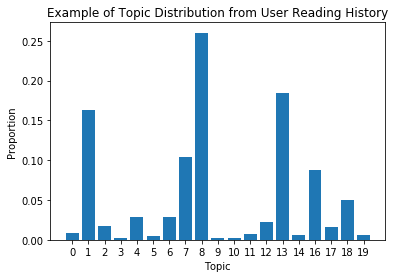

In [41]:
print("Entr {:.4f}".format(stats.entropy(list(norm_topic_distr.values()), base=10)))
print("std {:.4f} \n".format(np.std(list(norm_topic_distr.values()))))

plt.bar([str(i) for i in norm_topic_distr.keys()], norm_topic_distr.values())
plt.xlabel("Topic")
plt.ylabel("Proportion")
plt.title("Example of Topic Distribution from User Reading History")

In [12]:
def compute_user_topic_distribution(lda_model, articles_read, art_len=30, n_largest_topic_scores=5):
    
    u_hist, ts = zip(*sorted(articles_read, key=lambda tup: tup[1]))
    
    u_topic_distr = defaultdict(float)

    # get topic distr for each article & aggregate 'n_largest' scores
    for art_id in u_hist:
        for idx, score in sorted(lda_model[corpus[art_id2idx[art_id]][:art_len]][0], key=lambda tup: tup[1], reverse=True)[:n_largest_topic_scores]:
            u_topic_distr[idx] += score
        
    # normalise
    norm = np.sum(list(u_topic_distr.values()))
    norm_topic_distr = {idx: score/norm for idx, score in sorted(u_topic_distr.items(), key=lambda tup: tup[0])}
    
    return norm_topic_distr, len(u_hist)

def plot_user_topic_distr(u_topic_dist, n_topics=20):
    print("Entr {:.4f}".format(stats.entropy(list(u_topic_dist.values()))))
    print("std {:.4f} \n".format(np.std(list(u_topic_dist.values()))))
    
    
    
    tp_idx, scores = zip(*[(str(idx), score) for idx, score in sorted(u_topic_dist.items(), key=lambda tup: tup[0])])
    #print(len(scores))
    tp_idx, scores = [], []
    for i in range(n_topics):
        if i in u_topic_dist:
            scores.append(u_topic_dist[i])
        else:
            scores.append(0.0)
        
        tp_idx.append(str(i))
    
    plt.bar(tp_idx, scores) # [str(i) for i in u_topic_dist.keys()]
    plt.xlabel("Topic")

In [125]:
len(lda_model.print_topics())

20

Entr 2.1820
std 0.0723 

19


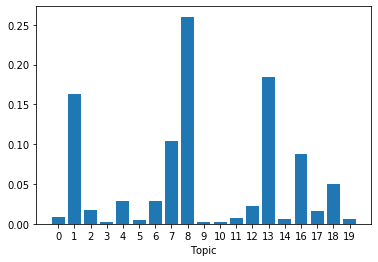

In [99]:
n=5

tp_distr, hist_len = compute_user_topic_distribution(lda_model, user_data['0051f142-a28d-44c2-884d-592c608fa4b1']['articles_read'], n_largest_topic_scores=n)
plot_user_topic_distr(tp_distr)

In [127]:
tp_distr.items()

dict_items([(0, 0.004295461362910138), (1, 0.1956700074492237), (2, 0.01562575983769856), (3, 0.021609553507490557), (4, 0.01708311898216), (5, 0.0046593899682287705), (6, 0.03723621732218161), (7, 0.11282801712149255), (8, 0.22355165929463944), (9, 0.018475282296041635), (10, 0.0014629422376849662), (11, 0.0018453004250090033), (12, 0.05361518155542576), (13, 0.17630445246522683), (15, 0.003142378507733612), (16, 0.01702789572843949), (17, 0.05605828190724404), (18, 0.03877672676845205), (19, 0.0007323732627172848)])

In [193]:
# how can we aggregate individual user topic distribution into metric? 
# i.e. homogenity score
# standard deviation of topic distribution: higher score = more homogenuous, i.e. few, dominant topics

In [155]:
# how can we aggregate ALL user topic distribution into representative metric?

0.010526315789473684

In [44]:
l = [0.2 / 19] * 19+ [0.8]

In [45]:
np.std(l)

0.17206180040292132

In [50]:
stats.entropy(l, base=10)

0.4730727314642145

In [51]:
l = [0.0] * 19 + [1.0]
np.std(l)

0.21794494717703367

In [54]:
stats.entropy(l)

0.0

In [13]:
def smooth(y, box_pts, n_first_valid=None):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    if n_first_valid is not None:
        valid_conv = np.convolve(y, box, mode='valid')
        y_smooth[:n_first_valid] = valid_conv[:n_first_valid]
        y_smooth[-2:] = valid_conv[-2:]
    return y_smooth


def link_hl2topic_scores(lda_model, art_len=100, n_largest_topics=5, min_hl=0, max_hl=1000, entr_base=None):
    hl_tp_std, hl_tp_entr = defaultdict(list), defaultdict(list)
    for u_id in user_data:
        norm_topic_distr, hist_len = compute_user_topic_distribution(lda_model, user_data[u_id]['articles_read'], 
                                                                     art_len=art_len, n_largest_topic_scores=n_largest_topics)
        
        tp_std= np.std(list(norm_topic_distr.values()))
        if entr_base is not None:
            tp_entr=stats.entropy(list(norm_topic_distr.values()), base=entr_base)
        else:
            tp_entr=stats.entropy(list(norm_topic_distr.values()))
        
        hl_tp_std[hist_len].append(tp_std)
        hl_tp_entr[hist_len].append(tp_entr)
        
        user_data[u_id]['topic_std'] = tp_std
        user_data[u_id]['topic_entr'] = tp_entr
        
    return hl_tp_std, hl_tp_entr

In [16]:
%%time

hl_tp_std, hl_tp_entr = link_hl2topic_scores(lda_model, art_len=30, n_largest_topics=5)

CPU times: user 52min 45s, sys: 39.6 s, total: 53min 24s
Wall time: 17min 49s


In [17]:
def plot_entropy_std_topic_distr(hl_tp_std, hl_tp_entr, fig_size=(12, 8)):

    fig = plt.figure(figsize=fig_size)


    hist_lens, entrs, s_entr = zip(*sorted([(hl, np.mean(vals), len(vals)) for hl, vals in hl_tp_entr.items()], key = lambda t: t[0]))

    plt.subplot(211)
    plt.scatter(hist_lens, entrs, s=s_entr, alpha=0.6)
    plt.plot(hist_lens, smooth(entrs, 5, 3), color="orange", label="Entropy (smooth)")

    mean=True
    if mean:
        plt.axhline(np.mean(entrs), color='red', linestyle='--', label="mean: {:.3f}".format(np.mean(entrs)))
    else:
        plt.axhline(np.median(entrs), color='red', linestyle='--', label="median: {:.3f}".format(np.median(entrs)))
    plt.xlabel("History Length")
    plt.ylabel("Entropy score")
    plt.title("Entropy")
    #plt.ylim(2.5, 2.9)
    plt.legend()
    # high entropy indicates higher uncertainty, i.e. topical diversity
    # low entropy = less uncertain = homogenuous

    hist_lens, stds, s_std = zip(*sorted([(hl, np.mean(vals), len(vals)) for hl, vals in hl_tp_std.items()], key = lambda t: t[0]))

    plt.subplot(212)
    plt.scatter(hist_lens, stds, s=s_std, alpha=0.6)
    plt.plot(hist_lens, smooth(stds, 5, 3), color="orange", label="Topic STD (smooth)")

    #plt.plot(x, smooth(y_mrr, 10), label="MRR (smooth)")
    #plt.plot(x, y, label="AUC")
    plt.axhline(np.mean(stds), color='red', linestyle='--', label="mean: {:.3f}".format(np.mean(stds)))
    plt.xlabel("History Length")
    plt.ylabel("STD score")
    plt.ylim(0.06, 0.08)
    plt.title("Standard Devidation (STD)")
    plt.legend()

    return fig


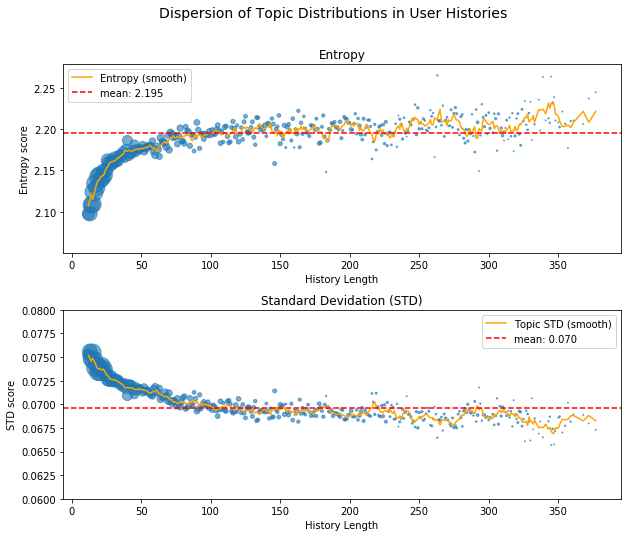

In [18]:
fig = plot_entropy_std_topic_distr(hl_tp_std, hl_tp_entr, fig_size=(10, 8))
fig.suptitle("Dispersion of Topic Distributions in User Histories", fontsize=14)
fig.subplots_adjust(hspace=0.3)

res_dir="./plots/draft_01/"
plt.savefig(res_dir + "01_topic_distr_no_min_hl.png", dpi=400, bbox_inches='tight')

### Show two examples of low and high homogeneuous distribituons

In [19]:
u_df = pd.DataFrame.from_dict(user_data, orient='index')
u_df = u_df.drop(['opened_pushes', 'articles_pushed'], axis=1)
u_df.head()

,articles_read,articles_train,articles_test,n_arts_read,topic_std,topic_entr
000016a9-6665-442b-87f1-662efa7d1b13,"[(f7db535, 1573973552), (1128216, 1574049451),...","[[2ee393d, 1574224464], [64b8b01, 1574397271],...","[[3af2b58, 1575150291], [5c76ef6, 1575150176],...",43,0.071012,2.193392
0005d90e-9af4-455f-98da-3070c060a99d,"[(f964e1a, 1572588703), (83f248a, 1572641235),...","[[6b8951d, 1573584003], [90a8595, 1574023608],...","[[f9463e5, 1575040172], [8ab4daa, 1575023622],...",66,0.072210,2.163547
0006af13-73d5-417e-be70-02dc4bd32661,"[(b687ca3, 1572588902), (765e5d8, 1572820240),...","[[15dd1da, 1574195619], [b687ca3, 1572588902],...","[[9cdaec0, 1574585754], [7d1efa5, 1574704731],...",21,0.077032,2.088667
000970cc-a98e-49a4-a2fc-c7ba4e404441,"[(ae18dcd, 1572600735), (abfc315, 1572742216),...","[[18766b6, 1573823972], [eab4beb, 1573824015],...","[[5933d2c, 1574596228], [10d25e6, 1574596193],...",37,0.076177,2.084761
000a5325-012c-4bf6-91b2-e9ed817f282b,"[(9b0e87d, 1572596921), (440cd81, 1572631298),...","[[0421aa2, 1574152678], [b9f2f78, 1573329164],...","[[66f2aaa, 1574867938], [db41b37, 1574867976],...",67,0.074763,2.097324


In [23]:
shorts = list(u_df[(u_df['n_arts_read'] < 30) & (u_df['topic_std'] > 0.073)].index)
print(len(shorts))
longs = list(u_df[(u_df['n_arts_read'] > 100) & (u_df['topic_entr'] > 2.2)].index)

2275


169a91aa-5a06-4210-83e2-b8a23a0dde38
Entr 1.8998
std 0.0918 



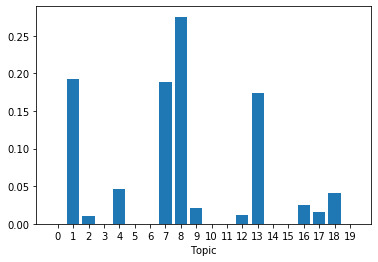

In [41]:
n=5

u_id = random.choice(shorts)

print(u_id)
tp_distr, hist_len = compute_user_topic_distribution(lda_model, user_data[u_id]['articles_read'], n_largest_topic_scores=n)

plot_user_topic_distr(tp_distr)

79261be3-3907-4f91-a158-87550bd527ee
Entr 2.2631
std 0.0659 



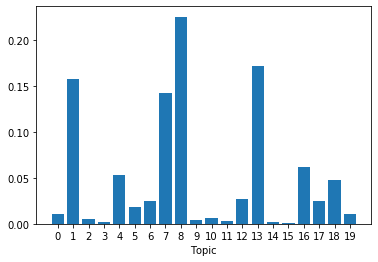

In [37]:
n=5

u_id = random.choice(longs)

print(u_id)
tp_distr, hist_len = compute_user_topic_distribution(lda_model, user_data[u_id]['articles_read'], n_largest_topic_scores=n)

plot_user_topic_distr(tp_distr)